# Learning Dynamics

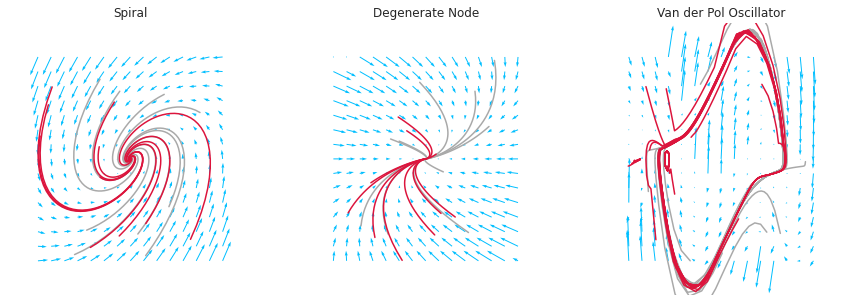

In [24]:
import pysia as sia
from dynamics import *

generator = sia.Generator.instance()
generator.seed(10)

dt=1e-1
q=1e-2
systems = {
    "Spiral": create_spiral(process_noise=q, dt=dt),
    "Degenerate Node": create_degenerate_node(process_noise=q, dt=dt),
    "Van der Pol Oscillator": create_van_der_pol(process_noise=q, dt=dt),
}

# Plot the recorded states
f, ax = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
sns.despine(f, left=True, bottom=True)
ax = ax.flatten()

sampler = sia.Uniform(lower=np.array([-3, -3]), upper=np.array([3, 3]))
n_trials = 10
n_steps = 100
n_clusters = 7
i = 0
for name, dynamics in systems.items():
    # Generate some samples, collect training data
    D = np.zeros((5, n_steps * n_trials))
    for j in range(n_trials):
        X = np.zeros((2, n_steps+1))
        X[:, 0] = sampler.sample()
        U = np.zeros((1, n_steps+1))
        for k in range(n_steps):
            X[:, k+1] = dynamics.f(X[:, k], U[:, k])
        D[:2, j*n_steps:(j+1)*n_steps] = X[:,:-1]
        D[2:3, j*n_steps:(j+1)*n_steps] = U[:,:-1]
        D[3:, j*n_steps:(j+1)*n_steps] = X[:,1:]
        ax[i].plot(X[0, :], X[1, :], color="darkgray")
        
    # Generate a GMR model of the dynamics
    model = sia.GMRDynamics(Xk=D[:2,:],
                            Uk=D[2:3,:],
                            Xkp1=D[3:,:], 
                            K=n_clusters)
    
    # Plot the vector field of the model
    x = np.linspace(-3, 3, 15)
    y = np.linspace(-3, 3, 15)
    n = len(x) * len(y)
    xk, yk = np.meshgrid(x, y)
    xy = np.vstack((np.reshape(xk, (n,)), np.reshape(yk, (n,))))
    _, n = np.shape(xy)
    xp = np.array([model.f(xy[:,i], np.zeros(1)) for i in range(n)]).T
    xd = (np.reshape(xp[0,:], np.shape(xk)) - xk) / dt
    yd = (np.reshape(xp[1,:], np.shape(yk)) - yk) / dt
    ax[i].quiver(xk, yk, xd, yd, color="deepskyblue")
    
    # Roll out samples from the model
    for j in range(n_trials):
        X = np.zeros((2, n_steps+1))
        X[:, 0] = sampler.sample()
        U = np.zeros((1, n_steps+1))
        for k in range(n_steps):
            X[:, k+1] = model.f(X[:, k], U[:, k])
        ax[i].plot(X[0, :], X[1, :], color="crimson")
        
    ax[i].set_xlim([-4, 4])
    ax[i].set_ylim([-4, 4])
    ax[i].set_title(name)
    ax[i].axis("off")
    
    i += 1

Observations:
- GMR does poorly with Van der Pol oscillator, highly unstable outside of demonstration domain.  Need extra optimization step to tweak the clusters for regression?
- GPR does much better with Van der Pol oscillator, hyperparameter training takes too long for $n > 200$ data points.  Need L-BFGS-B optimizer?
- GPR: 0 mean prior assupmtion is flawed for discrete time systems, zero mean drives the state to 0 at the first time step, which results in very high derivative values.  Really want $x_{k+1} = x_{k}$ outside of demonstration domain.  Easier to just learn the continuous time model $\dot{x} = 0$ which gives the desired behavior, other option is to use a linear prior for discrete time dynamics.

$$
x_{k+1} = x_k
$$

$Y = x_{k+1}, U = x_k$

$Y = X^+ - X, X^+ = Y + X$

- GMR: vectors explode outside of cluster domain.  Source unknown.. numerical issues?